# Fire Detection

## Import

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

The folder comes from the following link : https://www.kaggle.com/datasets/phylake1337/fire-dataset

## Separate DataSet

In [2]:
data_dir = 'data/fire_dataset'

import splitfolders

splitfolders.ratio('data/fire_dataset', output='data/separated_fire_dataset', seed=1337, ratio=(0.80, 0.20,0))

Copying files: 999 files [00:01, 962.11 files/s] 


## Loading DataSet

In [3]:
Scale = 500
batch_size = 6

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(Scale),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
    ]),
    'val': transforms.Compose([
        transforms.Resize(Scale + 20),
        transforms.CenterCrop(Scale),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25])
    ]),
}

data_dir = 'data/separated_fire_dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Display Images

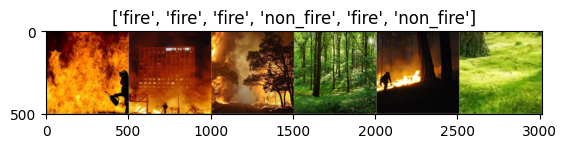

In [4]:
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.25, 0.25, 0.25])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Statistics

In [5]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

train_loss_resnet = []
train_acc_resnet = []
val_loss_resnet = []
val_acc_resnet = []

## Defining the training for the model

In [6]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if name == "conv":
                if phase == 'train':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                if phase == 'val':
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
            
            if name == "resnet":
                if phase == 'train':
                    train_loss_resnet.append(epoch_loss)
                    train_acc_resnet.append(epoch_acc)
                if phase == 'val':
                    val_loss_resnet.append(epoch_loss)
                    val_acc_resnet.append(epoch_acc)
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Function to display some predictions

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Testing 2 models

## 1) Convolutional Neural Network

In [8]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(int((((Scale-2)/2)-2)/2)**2*32, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 2)
    
    def forward(self, x):
        
        #print(x.shape)
        x = self.act1(self.conv1(x))
        #print(x.shape)
        x = self.pool1(x)
        #print(x.shape)
        
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        #print(x.shape)

        x = self.flat(x)

        #print(x.shape)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)

        return x

model_conv = Net()

model_conv = model_conv.to(device)

criterion_conv = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print(model_conv)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=484128, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=512, out_features=2, bias=True)
)


## Train and evaluate

In [9]:
model_conv = train_model(model_conv, criterion_conv, optimizer_conv, exp_lr_scheduler_conv, "conv",
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3974 Acc: 0.8285
val Loss: 0.1692 Acc: 0.9648

Epoch 1/24
----------
train Loss: 0.2404 Acc: 0.9149
val Loss: 0.1197 Acc: 0.9648

Epoch 2/24
----------
train Loss: 0.1903 Acc: 0.9387
val Loss: 0.1295 Acc: 0.9548

Epoch 3/24
----------
train Loss: 0.1769 Acc: 0.9399
val Loss: 0.1348 Acc: 0.9598

Epoch 4/24
----------
train Loss: 0.1637 Acc: 0.9449
val Loss: 0.0847 Acc: 0.9749

Epoch 5/24
----------
train Loss: 0.1700 Acc: 0.9449
val Loss: 0.0796 Acc: 0.9749

Epoch 6/24
----------
train Loss: 0.1684 Acc: 0.9499
val Loss: 0.0924 Acc: 0.9648

Epoch 7/24
----------
train Loss: 0.1254 Acc: 0.9487
val Loss: 0.0838 Acc: 0.9698

Epoch 8/24
----------
train Loss: 0.1276 Acc: 0.9650
val Loss: 0.0742 Acc: 0.9749

Epoch 9/24
----------
train Loss: 0.1099 Acc: 0.9612
val Loss: 0.0736 Acc: 0.9799

Epoch 10/24
----------
train Loss: 0.1187 Acc: 0.9537
val Loss: 0.0698 Acc: 0.9799

Epoch 11/24
----------
train Loss: 0.1139 Acc: 0.9612
val Loss: 0.0636 Acc: 0.9749

Ep

## Display some predictions

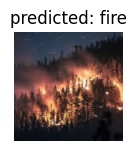

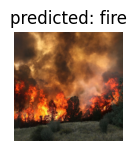

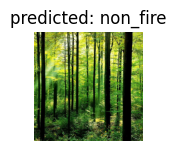

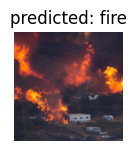

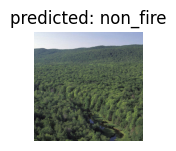

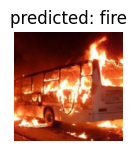

In [10]:
visualize_model(model_conv)

## 2) Resnet Model

In [11]:
model_resnet = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs_resnet = model_resnet.fc.in_features


model_resnet.fc = nn.Linear(num_ftrs_resnet, 2)

model_resnet = model_resnet.to(device)

criterion_resnet = nn.CrossEntropyLoss()

optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

## Train and evaluate

In [12]:
model_resnet = train_model(model_resnet, criterion_resnet, optimizer_resnet, exp_lr_scheduler_resnet, "resnet",
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2421 Acc: 0.8899
val Loss: 0.0519 Acc: 0.9950

Epoch 1/24
----------
train Loss: 0.1754 Acc: 0.9337
val Loss: 0.0321 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1584 Acc: 0.9512
val Loss: 0.0362 Acc: 0.9950

Epoch 3/24
----------
train Loss: 0.0777 Acc: 0.9775
val Loss: 0.0427 Acc: 0.9849

Epoch 4/24
----------
train Loss: 0.1252 Acc: 0.9487
val Loss: 0.0223 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1020 Acc: 0.9650
val Loss: 0.0455 Acc: 0.9799

Epoch 6/24
----------
train Loss: 0.0941 Acc: 0.9687
val Loss: 0.0393 Acc: 0.9899

Epoch 7/24
----------
train Loss: 0.0899 Acc: 0.9787
val Loss: 0.0283 Acc: 0.9849

Epoch 8/24
----------
train Loss: 0.0444 Acc: 0.9875
val Loss: 0.0259 Acc: 0.9899

Epoch 9/24
----------
train Loss: 0.0543 Acc: 0.9800
val Loss: 0.0220 Acc: 0.9950

Epoch 10/24
----------
train Loss: 0.0540 Acc: 0.9812
val Loss: 0.0172 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0775 Acc: 0.9800
val Loss: 0.0257 Acc: 0.9950

Ep

## Display some predictions

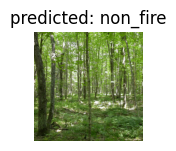

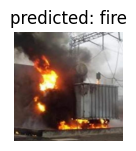

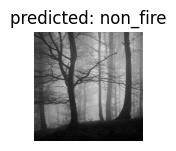

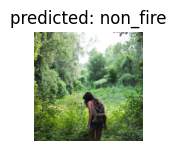

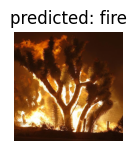

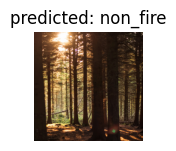

In [13]:
visualize_model(model_resnet)

## Tensorboard Statistics

In [14]:
from torch.utils.tensorboard import SummaryWriter

writer_conv = SummaryWriter()


for n_iter in range(25):
    writer_conv.add_scalar('Loss/train', train_loss[n_iter], n_iter)
    writer_conv.add_scalar('Loss/test', val_loss[n_iter], n_iter)
    writer_conv.add_scalar('Accuracy/train', train_acc[n_iter], n_iter)
    writer_conv.add_scalar('Accuracy/test', val_acc[n_iter], n_iter)

writer_conv.close()

writer_resnet = SummaryWriter()

for n_iter in range(25):
    writer_resnet.add_scalar('Loss/train', train_loss_resnet[n_iter], n_iter)
    writer_resnet.add_scalar('Loss/test', val_loss_resnet[n_iter], n_iter)
    writer_resnet.add_scalar('Accuracy/train', train_acc_resnet[n_iter], n_iter)
    writer_resnet.add_scalar('Accuracy/test', val_acc_resnet[n_iter], n_iter)

writer_resnet.close()


## Confusion matrix

In [29]:
true_label = []
predicted_label_conv = []
predicted_label_resnet = []

for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs_conv = model_conv(inputs)
            _, preds_conv = torch.max(outputs_conv, 1)

            outputs_resnet = model_resnet(inputs)
            _, preds_resnet = torch.max(outputs_resnet, 1)

            for i in range(len(labels)):
                    
                true_label.append(labels[i].cpu())
                predicted_label_conv.append(preds_conv[i].cpu())
                predicted_label_resnet.append(preds_resnet[i].cpu())



## Convolutional Neural Network 

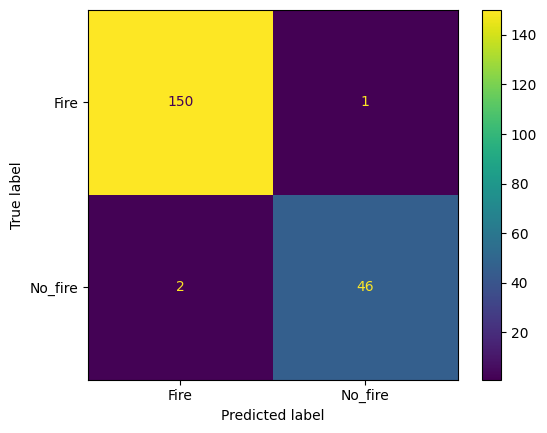

In [30]:
import matplotlib.pyplot as plt
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(true_label, predicted_label_conv)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Fire", "No_fire"])

cm_display.plot()
plt.show()

## Resnet Model

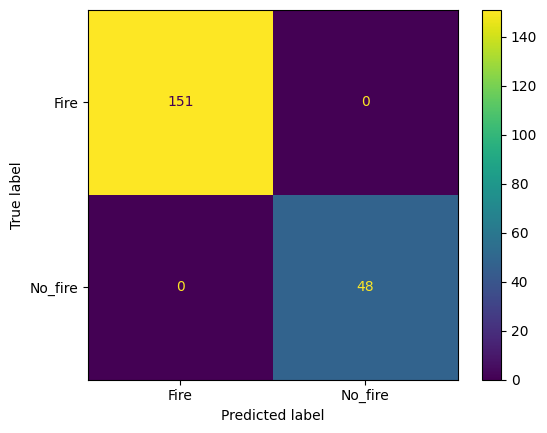

In [32]:
confusion_matrix = metrics.confusion_matrix(true_label, predicted_label_resnet)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Fire", "No_fire"])

cm_display.plot()
plt.show()